In [1]:
import warnings
warnings.filterwarnings("ignore")
import keras.backend as K
import csv;
import numpy as np
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer
import keras
from keras.models import Sequential,Model
from keras import optimizers
from keras.layers import Dense, Activation, Dropout, Conv1D,MaxPooling1D,Flatten,Concatenate,concatenate,Input,AveragePooling1D
from keras.layers.merge import concatenate
from keras.utils.vis_utils import plot_model
from sklearn.metrics import accuracy_score,hamming_loss
from sklearn.metrics import *
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'
K.common.image_dim_ordering()

Using TensorFlow backend.


'tf'

In [2]:
def f1_score(y_true, y_pred):

    # Count positive samples.
    c1 = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    c2 = K.sum(K.round(K.clip(y_pred, 0, 1)))
    c3 = K.sum(K.round(K.clip(y_true, 0, 1)))

    # If there are no true samples, fix the F1 score at 0.
    if c3 == 0:
        return 0

    # How many selected items are relevant?
    precision = c1 / c2

    # How many relevant items are selected?
    recall = c1 / c3

    # Calculate f1_score
    f1_score = 2 * (precision * recall) / (precision + recall)
    return f1_score


def precision(y_true, y_pred):

    # Count positive samples.
    c1 = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    c2 = K.sum(K.round(K.clip(y_pred, 0, 1)))
    

    # How many selected items are relevant?
    precision = c1 / c2

    return precision

def recall(y_true, y_pred):

    # Count positive samples.
    c1 = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    c3 = K.sum(K.round(K.clip(y_true, 0, 1)))

    # If there are no true samples, fix the F1 score at 0.
    if c3 == 0:
        return 0

    # How many relevant items are selected?
    recall = c1 / c3

    return recall

def hamming_loss(y_true, y_pred):
    # Avoid divide by 0
    y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
    # Multi-task loss
    return K.mean(K.sum(- y_true * K.log(y_pred) - (1 - y_true) * K.log(1 - y_pred), axis=1))
def hamming_score(y_true, y_pred, normalize=True, sample_weight=None):
    '''
    Compute the Hamming score (a.k.a. label-based accuracy) for the multi-label case
    http://stackoverflow.com/q/32239577/395857
    '''
    acc_list = []
    for i in range(y_true.shape[0]):
        set_true = set( np.where(y_true[i])[0] )
        set_pred = set( np.where(y_pred[i])[0] )
        tmp_a = None
        if len(set_true) == 0 and len(set_pred) == 0:
            tmp_a = 1
        else:
            tmp_a = len(set_true.intersection(set_pred))/float(len(set_true.union(set_pred)) )
        acc_list.append(tmp_a)
    return np.mean(acc_list)

In [3]:
xtraindf=pd.read_csv("train8em.csv")
ytraindf=pd.read_csv("trainlbl8em.csv")
xtestdf=pd.read_csv("test8em.csv")
ytestdf=pd.read_csv("testlbl8em.csv")

In [4]:
x_train=np.array(xtraindf.iloc[:,2:],dtype=float)
x_test=np.array(xtestdf.iloc[:,2:],dtype=float)

In [5]:
y_train=np.array(ytraindf.iloc[:,8])
y_test=np.array(ytestdf.iloc[:,8])

In [6]:
import ast

y_train=pd.DataFrame(ytraindf.iloc[:,8])
y_train["classes"]=y_train["classes"].apply(lambda x: [i.strip() for i in ast.literal_eval(x)])

y_test=pd.DataFrame(ytestdf.iloc[:,8])
y_test["classes"]=y_test["classes"].apply(lambda x: [i.strip() for i in ast.literal_eval(x)])

In [7]:
mlb = MultiLabelBinarizer(classes=("anger","anticipation","disgust","fear","joy","sad","surprise","trust"))
y_enc = mlb.fit_transform(y_train["classes"])
ytest_enc=mlb.fit_transform(y_test["classes"])

In [8]:
from skmultilearn.problem_transform import BinaryRelevance
from sklearn.naive_bayes import GaussianNB 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_validate
from sklearn.model_selection import ShuffleSplit

cv = ShuffleSplit( n_splits=10, test_size=0.34, random_state=0)
Gnb = BinaryRelevance(classifier = GaussianNB())
scores= cross_validate(Gnb, x_train, y_enc, cv=cv, return_train_score=True)
print("val scores",scores)
Gnb.fit(x_train,y_enc)
Gnb_pred=Gnb.predict(x_test)
score=hamming_score(ytest_enc,Gnb_pred.toarray())
#loss=hamming_loss(ytest_enc,Gnb_pred.toarray())
print("score",score)
print("NB jaccard_score (samples):",jaccard_score(ytest_enc,Gnb_pred.toarray(),average="samples"))
print("NB jaccard_score (micro):",jaccard_score(ytest_enc,Gnb_pred.toarray(),average="micro"))
print("NB jaccard_score (macro):",jaccard_score(ytest_enc,Gnb_pred.toarray(),average="macro"))

val scores {'fit_time': array([0.03124881, 0.03124046, 0.0312407 , 0.03124452, 0.03124475,
       0.03124237, 0.03124356, 0.01562166, 0.0312469 , 0.03123927]), 'score_time': array([0.01561546, 0.        , 0.01562166, 0.        , 0.01562095,
       0.        , 0.01562428, 0.01562357, 0.        , 0.01562905]), 'test_score': array([0.14873604, 0.14697237, 0.1228689 , 0.13521458, 0.14814815,
       0.12933568, 0.14050558, 0.16284539, 0.14873604, 0.14756026]), 'train_score': array([0.15913913, 0.1545923 , 0.13882995, 0.13458624, 0.15428918,
       0.1285238 , 0.15610791, 0.16065474, 0.15792664, 0.15519855])}
score 0.41133333333333333
NB jaccard_score (samples): 0.41133333333333333
NB jaccard_score (micro): 0.3753923414940364
NB jaccard_score (macro): 0.3241568485291261


In [9]:
svm = BinaryRelevance(classifier = SVC(probability=True))
scores= cross_validate(svm, x_train, y_enc, cv=cv, return_train_score=True)
print("val scores",scores)
svm.fit(x_train,y_enc)
svm_pred = svm.predict(x_test)
score=hamming_score(ytest_enc,svm_pred.toarray())
#loss=hamming_loss(ytest_enc,y_pred.toarray())
print("score",score)
print("svm jaccard_score (samples):",jaccard_score(ytest_enc,svm_pred.toarray(),average="samples"))
print("svm jaccard_score (micro):",jaccard_score(ytest_enc,svm_pred.toarray(),average="micro"))
print("svm jaccard_score (macro):",jaccard_score(ytest_enc,svm_pred.toarray(),average="macro"))

val scores {'fit_time': array([11.16957569, 11.20655346, 11.32495856, 11.96864724, 11.38519716,
       11.17630935, 12.05777287, 12.97664595, 13.92773581, 11.4217577 ]), 'score_time': array([0.71857977, 0.73419952, 0.73369455, 0.79668403, 0.71857762,
       0.74981833, 0.77527142, 1.0109098 , 0.76542687, 0.73419118]), 'test_score': array([0.39506173, 0.40152851, 0.3909465 , 0.39976484, 0.40858319,
       0.40505585, 0.39447384, 0.41269841, 0.39153439, 0.39741329]), 'train_score': array([0.43831464, 0.43346469, 0.43467717, 0.43134283, 0.42346166,
       0.43346469, 0.4349803 , 0.43528342, 0.43103971, 0.42800849])}
score 0.4609833333333333
svm jaccard_score (samples): 0.4609833333333333
svm jaccard_score (micro): 0.39615040286481645
svm jaccard_score (macro): 0.2712379678401869


In [10]:
knn = BinaryRelevance(classifier = KNeighborsClassifier())
scores= cross_validate(knn, x_train, y_enc, cv=cv, return_train_score=True)
print("val scores",scores)
knn.fit(x_train,y_enc)
knn_pred = knn.predict(x_test)
score=hamming_score(ytest_enc,knn_pred.toarray())
#loss=hamming_loss(ytest_enc,y_pred.toarray())
print("score",score)
print("knn jaccard_score (samples):",jaccard_score(ytest_enc,knn_pred.toarray(),average="samples"))
print("knn jaccard_score (micro):",jaccard_score(ytest_enc,knn_pred.toarray(),average="micro"))
print("knn jaccard_score (macro):",jaccard_score(ytest_enc,knn_pred.toarray(),average="macro"))

val scores {'fit_time': array([0.22413206, 0.23431778, 0.21869612, 0.21869946, 0.21869969,
       0.21867347, 0.24997377, 0.21869779, 0.21870637, 0.23431969]), 'score_time': array([2.69725966, 2.70249462, 2.81183481, 2.65562582, 2.65562248,
       2.80931067, 2.81183791, 2.72474527, 2.6555953 , 2.65560555]), 'test_score': array([0.27630805, 0.29982363, 0.28689006, 0.27748383, 0.28453851,
       0.29864785, 0.29276896, 0.2904174 , 0.28101117, 0.28042328]), 'train_score': array([0.4186117 , 0.40375871, 0.41376175, 0.39618066, 0.40830555,
       0.40739618, 0.4049712 , 0.39648378, 0.41103365, 0.40709306])}
score 0.43466666666666665
knn jaccard_score (samples): 0.43466666666666665
knn jaccard_score (micro): 0.36744560838033846
knn jaccard_score (macro): 0.25886839520576077


In [11]:
from sklearn.neural_network import MLPClassifier
mlp = BinaryRelevance(classifier =MLPClassifier(solver='sgd', alpha=1e-5, hidden_layer_sizes=(30,25,15), random_state=1))
scores= cross_validate(mlp, x_train, y_enc, cv=cv, return_train_score=True)
print("val scores",scores)
mlp.fit(x_train,y_enc)
mlp_pred = mlp.predict(x_test)
score=hamming_score(ytest_enc,mlp_pred.toarray())
#loss=hamming_loss(ytest_enc,y_pred.toarray())
print("score",score)
print("mlp jaccard_score (samples):",jaccard_score(ytest_enc,mlp_pred.toarray(),average="samples"))
print("mlp jaccard_score (micro):",jaccard_score(ytest_enc,mlp_pred.toarray(),average="micro"))
print("mlp jaccard_score (macro):",jaccard_score(ytest_enc,mlp_pred.toarray(),average="macro"))

val scores {'fit_time': array([16.86041856, 16.42988515, 16.01185727, 16.46800232, 16.65230894,
       14.80206656, 16.94992089, 15.35387778, 16.78253675, 15.73334718]), 'score_time': array([0.03120875, 0.03121018, 0.03121853, 0.03118348, 0.03121042,
       0.03120923, 0.03120303, 0.03120852, 0.03120399, 0.03120971]), 'test_score': array([0.33921223, 0.33274544, 0.33392122, 0.34803057, 0.35155791,
       0.34685479, 0.34861846, 0.35861258, 0.35508524, 0.3462669 ]), 'train_score': array([0.35768415, 0.36071537, 0.35677478, 0.36041225, 0.35465293,
       0.35344044, 0.35495605, 0.3461655 , 0.35586541, 0.35283419])}
score 0.44389999999999996
mlp jaccard_score (samples): 0.44389999999999996
mlp jaccard_score (micro): 0.3949579831932773
mlp jaccard_score (macro): 0.2701534078118012


In [12]:
n_timesteps,n_features=x_train.shape[0],x_train.shape[1]
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
model = models.Sequential()
model.add(layers.Dense(48,activation="relu",input_shape=(n_timesteps,n_features)))
model.add(layers.Dense(32,activation="relu"))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(8, activation='sigmoid'))
model.compile(optimizer='adam',
              loss=tf.keras.losses.binary_crossentropy,
              metrics=['categorical_accuracy'])
model.fit(x_train,y_enc, batch_size=100,epochs=70,validation_split=0.34)
model_ypred_prob=model.predict_proba(x_test)
model_ypred=model_ypred_prob
model_ypred[model_ypred >=0.5]=1
model_ypred[model_ypred <0.5]=0
#model.evaluate(x_train_y_train)
print("classification_report:",classification_report(ytest_enc,model_ypred))
print("hamming_score:",hamming_score(ytest_enc,model_ypred))
print("hamming_loss:",hamming_loss(ytest_enc,model_ypred))
print("DeepMLP jaccard_score (samples):",jaccard_score(ytest_enc,model_ypred,average="samples"))
print("DeepMLP jaccard_score (micro):",jaccard_score(ytest_enc,model_ypred,average="micro"))
print("DeepMLP jaccard_score (macro):",jaccard_score(ytest_enc,model_ypred,average="macro"))

Epoch 1/70
33/33 [==============================] - 0s 6ms/step - loss: 0.6719 - categorical_accuracy: 0.1791 - val_loss: 0.6364 - val_categorical_accuracy: 0.1370
Epoch 2/70
33/33 [==============================] - 0s 2ms/step - loss: 0.5961 - categorical_accuracy: 0.1507 - val_loss: 0.5690 - val_categorical_accuracy: 0.1370
Epoch 3/70
33/33 [==============================] - 0s 2ms/step - loss: 0.5426 - categorical_accuracy: 0.1507 - val_loss: 0.5283 - val_categorical_accuracy: 0.1370
Epoch 4/70
33/33 [==============================] - 0s 2ms/step - loss: 0.5062 - categorical_accuracy: 0.1534 - val_loss: 0.4979 - val_categorical_accuracy: 0.2357
Epoch 5/70
33/33 [==============================] - 0s 2ms/step - loss: 0.4820 - categorical_accuracy: 0.4877 - val_loss: 0.4742 - val_categorical_accuracy: 0.6167
Epoch 6/70
33/33 [==============================] - 0s 2ms/step - loss: 0.4559 - categorical_accuracy: 0.5917 - val_loss: 0.4416 - val_categorical_accuracy: 0.6314
Epoch 7/70
33/33

Epoch 46/70
33/33 [==============================] - 0s 3ms/step - loss: 0.2829 - categorical_accuracy: 0.7460 - val_loss: 0.2970 - val_categorical_accuracy: 0.7113
Epoch 47/70
33/33 [==============================] - 0s 2ms/step - loss: 0.2825 - categorical_accuracy: 0.7433 - val_loss: 0.2975 - val_categorical_accuracy: 0.7184
Epoch 48/70
33/33 [==============================] - 0s 2ms/step - loss: 0.2818 - categorical_accuracy: 0.7490 - val_loss: 0.3000 - val_categorical_accuracy: 0.6972
Epoch 49/70
33/33 [==============================] - 0s 2ms/step - loss: 0.2815 - categorical_accuracy: 0.7445 - val_loss: 0.2974 - val_categorical_accuracy: 0.7090
Epoch 50/70
33/33 [==============================] - 0s 1ms/step - loss: 0.2800 - categorical_accuracy: 0.7433 - val_loss: 0.2970 - val_categorical_accuracy: 0.7043
Epoch 51/70
33/33 [==============================] - 0s 2ms/step - loss: 0.2806 - categorical_accuracy: 0.7414 - val_loss: 0.2937 - val_categorical_accuracy: 0.7125
Epoch 52/7

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 5000, 48)          2112      
_________________________________________________________________
dense_1 (Dense)              (None, 5000, 32)          1568      
_________________________________________________________________
dense_2 (Dense)              (None, 5000, 16)          528       
_________________________________________________________________
dense_3 (Dense)              (None, 5000, 8)           136       
Total params: 4,344
Trainable params: 4,344
Non-trainable params: 0
_________________________________________________________________


In [14]:
x_train=np.expand_dims(x_train,axis=2)
x_test=np.expand_dims(x_test,axis=2)

In [15]:
n_timesteps,n_features=x_train.shape[1],x_train.shape[2]
model2 = models.Sequential()
model2.add(layers.Conv1D(filters=5, kernel_size=2, activation='relu', input_shape=(n_timesteps,n_features)))
model2.add(layers.AveragePooling1D(pool_size=2))
model2.add(layers.Flatten())
model2.add(layers.Dense(32, activation='relu'))
#model2.add(layers.Dense(16, activation='relu'))
model2.add(layers.Dense(8, activation='sigmoid'))
model2.compile(optimizer='adam',loss='binary_crossentropy',metrics=['categorical_accuracy'])
model2.fit(x_train,y_enc, batch_size=100,epochs=70,validation_split=0.34)

model2_ypred_prob=model2.predict_proba(x_test)
model2_ypred=model2_ypred_prob
model2_ypred[model2_ypred >=0.5]=1
model2_ypred[model2_ypred <0.5]=0
#model.evaluate(x_train_y_train)
print("classification_report:",classification_report(ytest_enc,model2_ypred))
print("hamming_score:",hamming_score(ytest_enc,model2_ypred))
print("hamming_loss:",hamming_loss(ytest_enc,model2_ypred))
print("accuracy_score:",accuracy_score(ytest_enc,model2_ypred))

print("cnn jaccard_score (samples):",jaccard_score(ytest_enc,model2_ypred,average="samples"))
print("cnn jaccard_score (micro):",jaccard_score(ytest_enc,model2_ypred,average="micro"))
print("cnn jaccard_score (macro):",jaccard_score(ytest_enc,model2_ypred,average="macro"))

Epoch 1/70
33/33 [==============================] - 0s 5ms/step - loss: 0.6582 - categorical_accuracy: 0.3116 - val_loss: 0.6061 - val_categorical_accuracy: 0.3898
Epoch 2/70
33/33 [==============================] - 0s 3ms/step - loss: 0.5464 - categorical_accuracy: 0.3998 - val_loss: 0.5083 - val_categorical_accuracy: 0.5044
Epoch 3/70
33/33 [==============================] - 0s 3ms/step - loss: 0.4907 - categorical_accuracy: 0.3362 - val_loss: 0.4882 - val_categorical_accuracy: 0.3821
Epoch 4/70
33/33 [==============================] - 0s 3ms/step - loss: 0.4819 - categorical_accuracy: 0.4908 - val_loss: 0.4824 - val_categorical_accuracy: 0.5732
Epoch 5/70
33/33 [==============================] - 0s 3ms/step - loss: 0.4757 - categorical_accuracy: 0.4110 - val_loss: 0.4755 - val_categorical_accuracy: 0.5561
Epoch 6/70
33/33 [==============================] - 0s 3ms/step - loss: 0.4685 - categorical_accuracy: 0.5296 - val_loss: 0.4681 - val_categorical_accuracy: 0.5485
Epoch 7/70
33/33

Epoch 51/70
33/33 [==============================] - 0s 3ms/step - loss: 0.3231 - categorical_accuracy: 0.6805 - val_loss: 0.3321 - val_categorical_accuracy: 0.7008
Epoch 52/70
33/33 [==============================] - 0s 2ms/step - loss: 0.3221 - categorical_accuracy: 0.6996 - val_loss: 0.3299 - val_categorical_accuracy: 0.6837
Epoch 53/70
33/33 [==============================] - 0s 3ms/step - loss: 0.3215 - categorical_accuracy: 0.6832 - val_loss: 0.3300 - val_categorical_accuracy: 0.6767
Epoch 54/70
33/33 [==============================] - 0s 3ms/step - loss: 0.3199 - categorical_accuracy: 0.6908 - val_loss: 0.3286 - val_categorical_accuracy: 0.6902
Epoch 55/70
33/33 [==============================] - 0s 3ms/step - loss: 0.3190 - categorical_accuracy: 0.6929 - val_loss: 0.3283 - val_categorical_accuracy: 0.6802
Epoch 56/70
33/33 [==============================] - 0s 3ms/step - loss: 0.3189 - categorical_accuracy: 0.6960 - val_loss: 0.3294 - val_categorical_accuracy: 0.6778
Epoch 57/7

In [16]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 42, 5)             15        
_________________________________________________________________
average_pooling1d (AveragePo (None, 21, 5)             0         
_________________________________________________________________
flatten (Flatten)            (None, 105)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 32)                3392      
_________________________________________________________________
dense_5 (Dense)              (None, 8)                 264       
Total params: 3,671
Trainable params: 3,671
Non-trainable params: 0
_________________________________________________________________


In [17]:
x_test=np.squeeze(x_test,axis=2)
Gnb_pred = Gnb.predict_proba(x_test)
svm_pred = svm.predict_proba(x_test)
knn_pred = knn.predict_proba(x_test)
mlp_pred = mlp.predict_proba(x_test)

avg_pred=(Gnb_pred.toarray()+svm_pred.toarray()+knn_pred.toarray()+mlp_pred.toarray()+model_ypred_prob+model2_ypred_prob)/6
avg_pred[avg_pred>=0.5]=1
avg_pred[avg_pred<0.5]=0
print("Averaging ensemble technique hamming score:",hamming_score(ytest_enc,avg_pred))
print("Average ensemble technique hamming loss:",hamming_loss(ytest_enc,avg_pred))
print("Average ensemble classification matrix:",classification_report(ytest_enc,avg_pred))
print("average ensemble jaccard_score (samples):",jaccard_score(ytest_enc,avg_pred,average="samples"))
print("average ensemble jaccard_score (micro):",jaccard_score(ytest_enc,avg_pred,average="micro"))
print("average ensemble jaccard_score (macro):",jaccard_score(ytest_enc,avg_pred,average="macro"))

Averaging ensemble technique hamming score: 0.48164999999999997
Average ensemble technique hamming loss: tf.Tensor(21.324241214088964, shape=(), dtype=float64)
Average ensemble classification matrix:               precision    recall  f1-score   support

           0       0.77      0.63      0.69       399
           1       0.82      0.64      0.72       368
           2       0.66      0.41      0.51       313
           3       0.67      0.01      0.03       152
           4       0.75      0.41      0.53       201
           5       0.71      0.61      0.66       401
           6       1.00      0.03      0.07        59
           7       0.00      0.00      0.00        53

   micro avg       0.74      0.49      0.59      1946
   macro avg       0.67      0.34      0.40      1946
weighted avg       0.72      0.49      0.55      1946
 samples avg       0.63      0.53      0.55      1946

average ensemble jaccard_score (samples): 0.48164999999999997
average ensemble jaccard_score (m

In [18]:
import statistics

Gnb_pred[Gnb_pred>=0.5]=1
Gnb_pred[Gnb_pred<0.5]=0

svm_pred[svm_pred>=0.5]=1
svm_pred[svm_pred<0.5]=0

knn_pred[knn_pred>=0.5]=1
knn_pred[knn_pred<0.5]=0

mlp_pred[mlp_pred>=0.5]=1
mlp_pred[mlp_pred<0.5]=0

voting_pred=[]
arr=[]
for row in range(0,x_test.shape[0]):
    arr=[]
    for column in range(0,8):
        arr.append(statistics.mode([svm_pred.toarray()[row,column],knn_pred.toarray()[row,column],
                                    Gnb_pred.toarray()[row,column]
                                    ,mlp_pred.toarray()[row,column],
                                   model_ypred[row,column]]))
    voting_pred.append(arr)
voting_pred=np.array(voting_pred,dtype=float)
print("SVM, KNN , MLP , NB")
print("Voting ensemble technique hamming score:",hamming_score(ytest_enc,voting_pred))
print("Voting ensemble technique hamming loss:",hamming_loss(ytest_enc,voting_pred))
print("Voting jaccard_score (samples):",jaccard_score(ytest_enc,voting_pred,average="samples"))
print("Voting jaccard_score (micro):",jaccard_score(ytest_enc,voting_pred,average="micro"))
print("Voting jaccard_score (macro):",jaccard_score(ytest_enc,voting_pred,average="macro"))
print("Voting ensemble classification matrix:",classification_report(ytest_enc,voting_pred))

SVM, KNN , MLP , NB
Voting ensemble technique hamming score: 0.47993333333333327
Voting ensemble technique hamming loss: tf.Tensor(21.27588692743556, shape=(), dtype=float64)
Voting jaccard_score (samples): 0.47993333333333327
Voting jaccard_score (micro): 0.4185022026431718
Voting jaccard_score (macro): 0.2939447861329519
Voting ensemble classification matrix:               precision    recall  f1-score   support

           0       0.76      0.62      0.68       399
           1       0.83      0.64      0.72       368
           2       0.68      0.42      0.52       313
           3       0.43      0.02      0.04       152
           4       0.74      0.43      0.55       201
           5       0.71      0.61      0.66       401
           6       1.00      0.03      0.07        59
           7       0.00      0.00      0.00        53

   micro avg       0.75      0.49      0.59      1946
   macro avg       0.64      0.35      0.40      1946
weighted avg       0.71      0.49      0

In [19]:
or1=np.logical_or(knn_pred.toarray(),model2_ypred,model_ypred)
or2=np.logical_or(Gnb_pred.toarray(),svm_pred.toarray(),mlp_pred.toarray())
or3=np.logical_or(or1,or2)
print("OR technique average accuracy:",accuracy_score(ytest_enc,or3))
print("OR technique hamming score:",hamming_score(ytest_enc,or3))
print("OR technique jaccard_score (samples):",jaccard_score(ytest_enc,or3,average="samples"))
print("OR technique jaccard_score (micro):",jaccard_score(ytest_enc,or3,average="micro"))
print("OR technique jaccard_score (macro):",jaccard_score(ytest_enc,or3,average="macro"))
print("OR classification matrix:",classification_report(ytest_enc,or3))

OR technique average accuracy: 0.103
OR technique hamming score: 0.44962857142857143
OR technique jaccard_score (samples): 0.44962857142857143
OR technique jaccard_score (micro): 0.4113250934176487
OR technique jaccard_score (macro): 0.3519474796008323
OR classification matrix:               precision    recall  f1-score   support

           0       0.62      0.80      0.70       399
           1       0.67      0.82      0.73       368
           2       0.45      0.71      0.55       313
           3       0.23      0.64      0.34       152
           4       0.45      0.64      0.53       201
           5       0.58      0.81      0.67       401
           6       0.22      0.29      0.25        59
           7       0.12      0.36      0.18        53

   micro avg       0.48      0.74      0.58      1946
   macro avg       0.42      0.63      0.50      1946
weighted avg       0.52      0.74      0.60      1946
 samples avg       0.50      0.76      0.57      1946



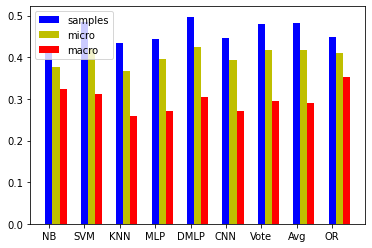

In [20]:
import matplotlib.pyplot as plt
x=['NB','SVM','KNN','MLP' ,'DMLP','CNN','Vote','Avg','OR']
y=[[jaccard_score(ytest_enc,Gnb_pred.toarray(),average="samples"),
   jaccard_score(ytest_enc,Gnb_pred.toarray(),average="micro"),
   jaccard_score(ytest_enc,Gnb_pred.toarray(),average="macro")],
   
  [jaccard_score(ytest_enc,svm_pred.toarray(),average="samples"),
  jaccard_score(ytest_enc,svm_pred.toarray(),average="micro"),
  jaccard_score(ytest_enc,svm_pred.toarray(),average="macro")],
   
  [jaccard_score(ytest_enc,knn_pred.toarray(),average="samples"),
   jaccard_score(ytest_enc,knn_pred.toarray(),average="micro"),
   jaccard_score(ytest_enc,knn_pred.toarray(),average="macro")],
   
  [jaccard_score(ytest_enc,mlp_pred.toarray(),average="samples"),
   jaccard_score(ytest_enc,mlp_pred.toarray(),average="micro"),
   jaccard_score(ytest_enc,mlp_pred.toarray(),average="macro")],
   
   [jaccard_score(ytest_enc,model_ypred,average="samples"),
   jaccard_score(ytest_enc,model_ypred,average="micro"),
   jaccard_score(ytest_enc,model_ypred,average="macro")],
  
   [jaccard_score(ytest_enc,model2_ypred,average="samples"),
   jaccard_score(ytest_enc,model2_ypred,average="micro"),
   jaccard_score(ytest_enc,model2_ypred,average="macro")],
   
  [jaccard_score(ytest_enc,voting_pred,average="samples"),
   jaccard_score(ytest_enc,voting_pred,average="micro"),
   jaccard_score(ytest_enc,voting_pred,average="macro")],
   
  [jaccard_score(ytest_enc,avg_pred,average="samples"),
   jaccard_score(ytest_enc,avg_pred,average="micro"),
   jaccard_score(ytest_enc,avg_pred,average="macro")],
   
  [jaccard_score(ytest_enc,or3,average="samples"),
   jaccard_score(ytest_enc,or3,average="micro"),
   jaccard_score(ytest_enc,or3,average="macro")]
  ]

for i in range(0,len(x)):
    plt.bar(i,y[i][0],color='b',width=0.2)
    plt.bar(i+0.2,y[i][1],color='y',width=0.2)
    plt.bar(i+0.4,y[i][2],color='r',width=0.2)
    
plt.legend(['samples','micro','macro'])
plt.xticks(ticks=np.arange(len(x)),labels=x)
plt.show()

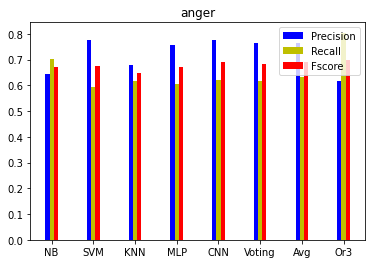

In [21]:
e=['anger','anticipation','disgust','fear','joy','sad','surprise','trust']
x=['NB','SVM','KNN','MLP','CNN','Voting','Avg','Or3']
y=[
    precision_recall_fscore_support(ytest_enc,Gnb_pred.toarray()),
    precision_recall_fscore_support(ytest_enc,svm_pred.toarray()),
    precision_recall_fscore_support(ytest_enc,knn_pred.toarray()),
    precision_recall_fscore_support(ytest_enc,mlp_pred.toarray()),
    precision_recall_fscore_support(ytest_enc,model2_ypred),
    precision_recall_fscore_support(ytest_enc,voting_pred),
    precision_recall_fscore_support(ytest_enc,avg_pred),
    precision_recall_fscore_support(ytest_enc,or3)
]

for i in range(0,len(x)):
    plt.bar(i-0.1,y[i][0][0],color='b',width=0.1)
    plt.bar(i,y[i][1][0],color='y',width=0.1)
    plt.bar(i+0.1,y[i][2][0],color='r',width=0.1)
    
    
plt.title('anger')
plt.legend(['Precision','Recall','Fscore'])
plt.xticks(ticks=np.arange(len(x)),labels=x)
plt.show()

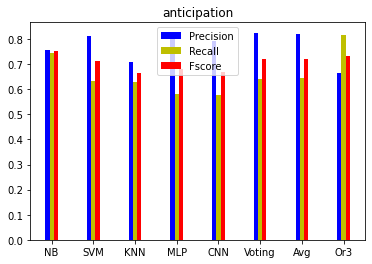

In [22]:
for i in range(0,len(x)):
    plt.bar(i-0.1,y[i][0][1],color='b',width=0.1)
    plt.bar(i,y[i][1][1],color='y',width=0.1)
    plt.bar(i+0.1,y[i][2][1],color='r',width=0.1)
    
    
plt.title('anticipation')
plt.legend(['Precision','Recall','Fscore'])
plt.xticks(ticks=np.arange(len(x)),labels=x)
plt.show()

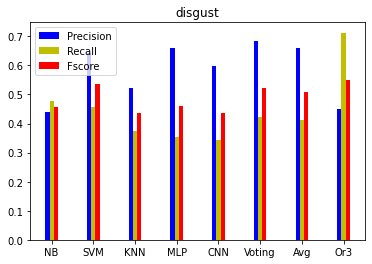

In [23]:
for i in range(0,len(x)):
    plt.bar(i-0.1,y[i][0][2],color='b',width=0.1)
    plt.bar(i,y[i][1][2],color='y',width=0.1)
    plt.bar(i+0.1,y[i][2][2],color='r',width=0.1)
    
    
plt.title('disgust')
plt.legend(['Precision','Recall','Fscore'])
plt.xticks(ticks=np.arange(len(x)),labels=x)
plt.show()

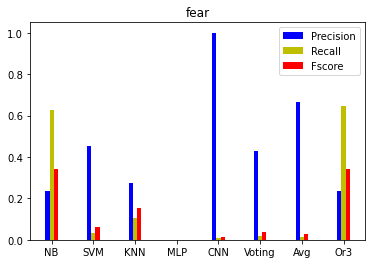

In [24]:
for i in range(0,len(x)):
    plt.bar(i-0.1,y[i][0][3],color='b',width=0.1)
    plt.bar(i,y[i][1][3],color='y',width=0.1)
    plt.bar(i+0.1,y[i][2][3],color='r',width=0.1)
    
    
plt.title('fear')
plt.legend(['Precision','Recall','Fscore'])
plt.xticks(ticks=np.arange(len(x)),labels=x)
plt.show()

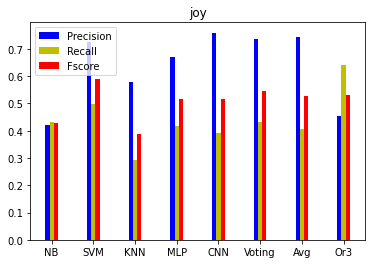

In [25]:
for i in range(0,len(x)):
    plt.bar(i-0.1,y[i][0][4],color='b',width=0.1)
    plt.bar(i,y[i][1][4],color='y',width=0.1)
    plt.bar(i+0.1,y[i][2][4],color='r',width=0.1)
    
    
plt.title('joy')
plt.legend(['Precision','Recall','Fscore'])
plt.xticks(ticks=np.arange(len(x)),labels=x)
plt.show()

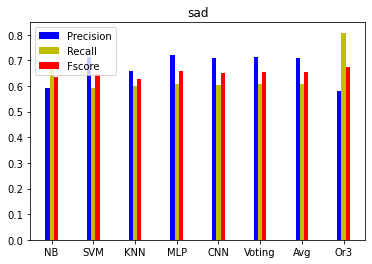

In [26]:
for i in range(0,len(x)):
    plt.bar(i-0.1,y[i][0][5],color='b',width=0.1)
    plt.bar(i,y[i][1][5],color='y',width=0.1)
    plt.bar(i+0.1,y[i][2][5],color='r',width=0.1)
    
    
plt.title('sad')
plt.legend(['Precision','Recall','Fscore'])
plt.xticks(ticks=np.arange(len(x)),labels=x)
plt.show()

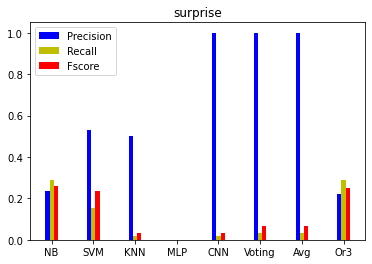

In [27]:
for i in range(0,len(x)):
    plt.bar(i-0.1,y[i][0][6],color='b',width=0.1)
    plt.bar(i,y[i][1][6],color='y',width=0.1)
    plt.bar(i+0.1,y[i][2][6],color='r',width=0.1)
    
    
plt.title('surprise')
plt.legend(['Precision','Recall','Fscore'])
plt.xticks(ticks=np.arange(len(x)),labels=x)
plt.show()

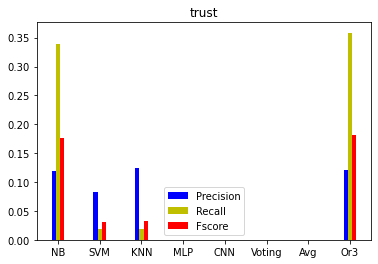

In [28]:
for i in range(0,len(x)):
    plt.bar(i-0.1,y[i][0][7],color='b',width=0.1)
    plt.bar(i,y[i][1][7],color='y',width=0.1)
    plt.bar(i+0.1,y[i][2][7],color='r',width=0.1)
    
    
plt.title('trust')
plt.legend(['Precision','Recall','Fscore'])
plt.xticks(ticks=np.arange(len(x)),labels=x)
plt.show()